In [83]:
import gc
import os

import scipy
from scipy.io import netcdf_file
import math

os.environ["CDF_LIB"] = "~/CDF/lib"
import datetime
import glob
import pickle

import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import spacepy
from spacepy import pycdf
from tqdm import tqdm
from scipy.stats import gaussian_kde
from matplotlib.collections import LineCollection
import matplotlib.dates as mdates
from matplotlib.colors import BoundaryNorm
import matplotlib.gridspec as grid_spec
import warnings
warnings.filterwarnings('ignore')



In [84]:
twins_dir = '../data/twins/'
supermag_dir = '../data/supermag/'
regions_dict = '../identifying_regions/outputs/twins_era_identified_regions_min_2.pkl'
regions_stat_dict = '../identifying_regions/outputs/twins_era_stats_dict_radius_regions_min_2.pkl'


region_numbers = [83, 143, 223, 44, 173, 321, 366, 383, 122, 279, 14, 95, 237, 26, 166, 86,
						387, 61, 202, 287, 207, 361, 137, 184, 36, 19, 9, 163, 16, 270, 194, 82,
						62, 327, 293, 241, 107, 55, 111]

In [85]:
times = pd.read_feather('outputs/regular_twins_map_dates.feather')

In [86]:
with open(regions_dict, 'rb') as f:
	regions = pickle.load(f)

regions = {f'region_{reg}': regions[f'region_{reg}'] for reg in region_numbers}

with open(regions_stat_dict, 'rb') as g:
	stats = pickle.load(g)

stats = {f'region_{reg}': stats[f'region_{reg}'] for reg in region_numbers}

In [87]:
def combining_regional_dfs(stations, rsd):

	start_time = pd.to_datetime('2010-01-01')
	end_time = pd.to_datetime('2017-12-31')
	twins_time_period = pd.date_range(start=start_time, end=end_time, freq='min')

	combined_stations = pd.DataFrame(index=twins_time_period)

	mlats = []

	for station in stations:
		stat = loading_supermag(station, start_time, end_time)
		mlats.append(stat['MLAT'].mean())
		combined_stations = pd.concat([combined_stations, stat['dbht']], axis=1, ignore_index=False)

	region_mlat = round((np.max(mlats) + np.min(mlats)) / 2, 2)

	mean_dbht = combined_stations.mean(axis=1)
	max_dbht = combined_stations.max(axis=1)

	combined_stations['reg_mean'] = mean_dbht
	combined_stations['reg_max'] = max_dbht
	combined_stations['rsd'] = rsd['max_rsd']
	combined_stations['MLT'] = rsd['MLT']

	return combined_stations, region_mlat


def loading_supermag(station, start_time, end_time):

	df = pd.read_feather(supermag_dir+station+'.feather')

	# limiting the analysis to the nightside
	df.set_index('Date_UTC', inplace=True, drop=True)
	df.index = pd.to_datetime(df.index, format='%Y-%m-%d %H:%M:$S')
	df = df[start_time:end_time]

	return df

In [88]:
dataframes = {}

for region in regions.keys():
	df, mlat = combining_regional_dfs(regions[region]['station'], stats[region]['max_rsd'])
	dataframes[region] = {'df': df, 'mlat': mlat}


In [89]:
keys = [key for key in dataframes.keys()]
df = dataframes[keys[27]]['df']
limit = 80
strt = limit-20
print(df['2010-05-04 09:40:00':'2010-05-04 11:40:00']['MLT'][strt:limit])


2010-05-04 10:40:00    23.700001
2010-05-04 10:41:00    23.719999
2010-05-04 10:42:00    23.740000
2010-05-04 10:43:00    23.750000
2010-05-04 10:44:00    23.770000
2010-05-04 10:45:00    23.780001
2010-05-04 10:46:00    23.799999
2010-05-04 10:47:00    23.750000
2010-05-04 10:48:00    23.770000
2010-05-04 10:49:00    23.780001
2010-05-04 10:50:00    23.799999
2010-05-04 10:51:00    23.809999
2010-05-04 10:52:00    23.830000
2010-05-04 10:53:00    23.850000
2010-05-04 10:54:00    23.860001
2010-05-04 10:55:00    23.879999
2010-05-04 10:56:00    23.889999
2010-05-04 10:57:00    23.910000
2010-05-04 10:58:00    23.930000
2010-05-04 10:59:00     0.200000
Freq: T, Name: MLT, dtype: float32


In [90]:
times = pd.to_datetime(times['dates'], format='%Y-%m-%d %H:%M:%S')

twins_files = sorted(glob.glob(twins_dir+'*.cdf', recursive=True))

maps = {}
maps_array = []

for file in twins_files:
	twins_map = pycdf.CDF(file)
	for i, date in enumerate(twins_map['Epoch']):
		check = pd.to_datetime(date.strftime(format='%Y-%m-%d %H:%M:%S'), format='%Y-%m-%d %H:%M:%S')
		if check in times.values:
			maps[check.round('T').strftime(format='%Y-%m-%d %H:%M:%S')] = twins_map['Ion_Temperature'][i][50:140,40:100]
			maps_array.append(twins_map['Ion_Temperature'][i][50:140,40:100])

In [91]:
for arr in maps_array:
	arr[arr ==-1] = np.nan

In [92]:
alg_maps = []
for arr in maps_array:
	alg_maps.append((arr-np.nanmean(arr)) / np.nanstd(arr))

In [150]:
i = 10571
dbdt_degree = 50
rsd_degree = 50
hours_before = 3
hours_after = 6

print(f'Mean: {np.nanmean(maps_array[i])}')
print(f'StD: {np.nanstd(maps_array[i])}')
print(f'Var: {np.nanvar(maps_array[i])}')
print(f'Min: {np.nanmin(maps_array[i])}')
print(f'Max: {np.nanmax(maps_array[i])}')

dates = [date for date in maps.keys()]
dates = [pd.to_datetime(date, format='%Y-%m-%d %H:%M:%S') for date in dates]

plot_start = dates[i] - pd.Timedelta(hours=hours_before)
plot_end = dates[i] + pd.Timedelta(hours=hours_after)
time_period = pd.date_range(start=plot_start, end=plot_end, freq='min')

Mean: 10.579063845312097
StD: 3.2752584109829455
Var: 10.72731765871453
Min: 4.56170459067747
Max: 20.339544849438578


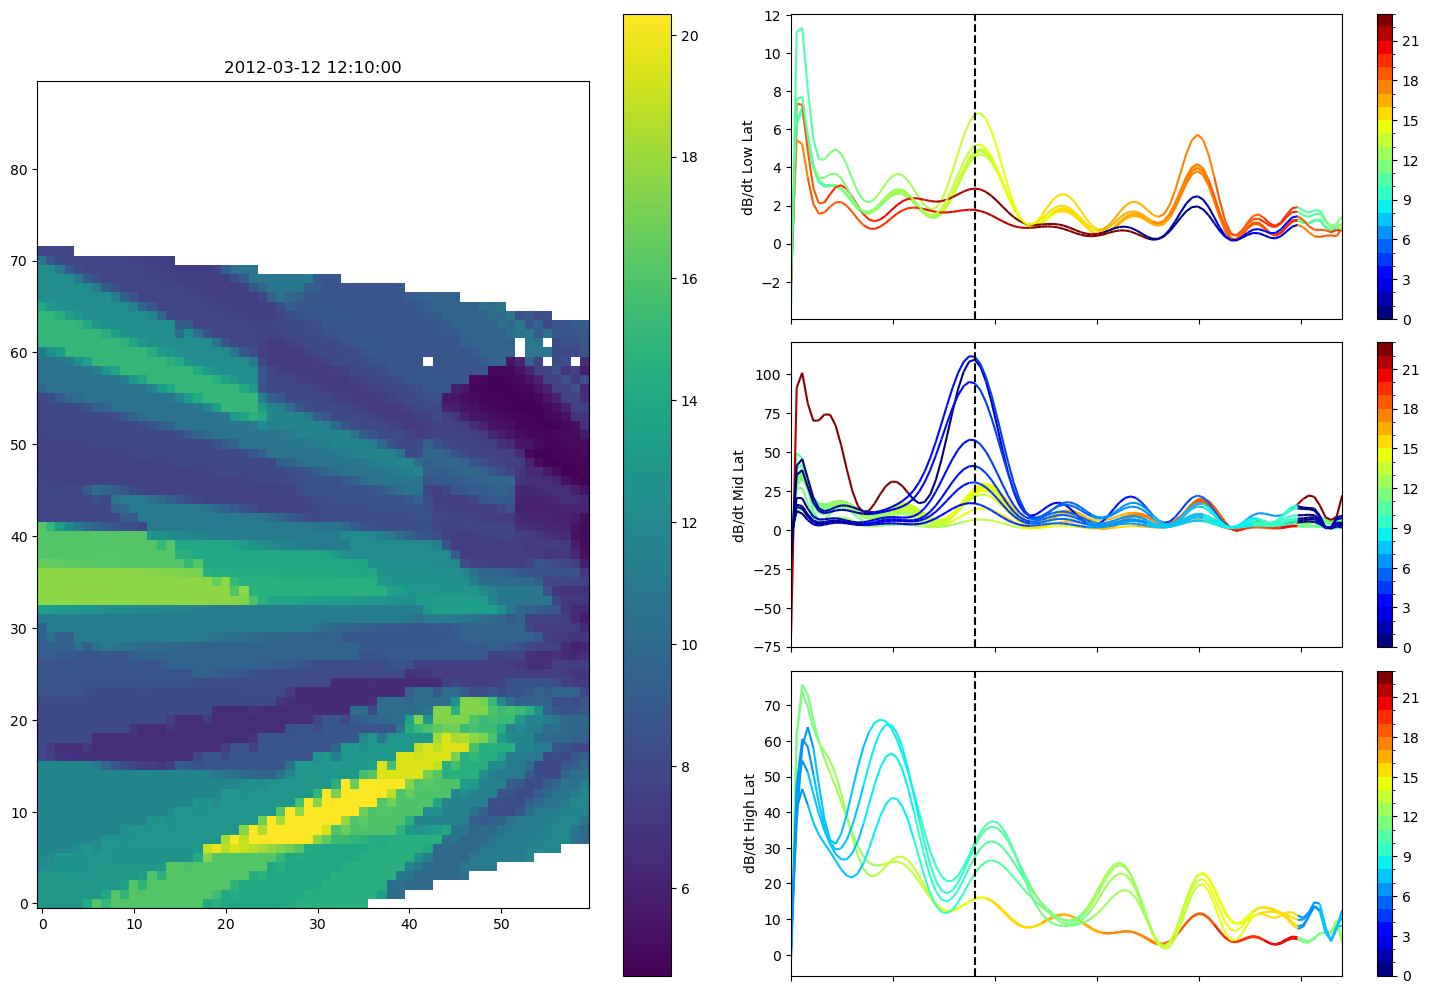

In [151]:
fig = plt.figure(figsize=(15,10))
ax1 = plt.subplot(121)
plt.imshow(maps_array[i], origin='lower')
plt.title(dates[i])
plt.colorbar()

colormap = plt.get_cmap('jet')
norm = BoundaryNorm([j for j in range(0,24)], colormap.N)

ax2 = plt.subplot(322)
for region in dataframes.keys():

	if dataframes[region]['mlat'] > 50:
		continue

	df = dataframes[region]['df']

	temp = df['reg_mean'][plot_start:plot_end].dropna(inplace=False)
	if len(temp) == 0:
		continue
	polyx = [n for n in range(len(temp))]

	polyy = temp.values

	coeff = np.polyfit(polyx, polyy, dbdt_degree)

	poly = np.poly1d(coeff)

	x_fit = np.linspace(min(polyx), max(polyx), 100)
	y_fit = poly(x_fit)

	inxval = mdates.date2num(df['reg_mean'][plot_start:plot_end].index)
	points = np.array([x_fit, y_fit]).T.reshape(-1,1,2)
	segments = np.concatenate([points[:-1], points[1:]], axis=1)

	lc = LineCollection(segments, cmap=colormap, norm=norm)
	mlt_coloring_array = [df['MLT'][plot_start:plot_end][m] for m in range(0,len(polyx), math.ceil(len(polyx)/100))]
	lc.set_array(mlt_coloring_array)
	ax2.add_collection(lc)

ax2.set_xticklabels([])
ax2.set_ylabel('dB/dt Low Lat')
ax2.autoscale_view()
plt.colorbar(lc)
plt.axvline(int((hours_before/(hours_before+hours_after))*len(time_period)), linestyle='--', color='black')
plt.margins(x=0)


ax3 = plt.subplot(324)
for region in dataframes.keys():

	if (dataframes[region]['mlat'] <= 50) or ((dataframes[region]['mlat'] > 70)):
		continue
	
	df = dataframes[region]['df']

	temp = df['reg_mean'][plot_start:plot_end].dropna(inplace=False)
	if len(temp) == 0:
		continue
	polyx = [n for n in range(len(temp))]

	polyy = temp.values

	coeff = np.polyfit(polyx, polyy, dbdt_degree)

	poly = np.poly1d(coeff)

	x_fit = np.linspace(min(polyx), max(polyx), 100)
	y_fit = poly(x_fit)

	inxval = mdates.date2num(df['reg_mean'][plot_start:plot_end].index)
	points = np.array([x_fit, y_fit]).T.reshape(-1,1,2)
	segments = np.concatenate([points[:-1], points[1:]], axis=1)

	lc = LineCollection(segments, cmap=colormap, norm=norm)
	mlt_coloring_array = [df['MLT'][plot_start:plot_end][m] for m in range(0,len(polyx), math.ceil(len(polyx)/100))]
	lc.set_array(mlt_coloring_array)
	ax3.add_collection(lc)

ax3.set_xticklabels([])
ax3.set_ylabel('dB/dt Mid Lat')
ax3.autoscale_view()
plt.colorbar(lc)
plt.axvline(int((hours_before/(hours_before+hours_after))*len(time_period)), linestyle='--', color='black')
plt.margins(x=0)

ax4 = plt.subplot(326)
for region in dataframes.keys():

	if dataframes[region]['mlat'] <= 70:
		continue
	
	df = dataframes[region]['df']

	temp = df['reg_mean'][plot_start:plot_end].dropna(inplace=False)
	if len(temp) == 0:
		continue
	polyx = [n for n in range(len(temp))]

	polyy = temp.values

	coeff = np.polyfit(polyx, polyy, dbdt_degree)

	poly = np.poly1d(coeff)

	x_fit = np.linspace(min(polyx), max(polyx), 100)
	y_fit = poly(x_fit)

	inxval = mdates.date2num(df['reg_mean'][plot_start:plot_end].index)
	points = np.array([x_fit, y_fit]).T.reshape(-1,1,2)
	segments = np.concatenate([points[:-1], points[1:]], axis=1)

	lc = LineCollection(segments, cmap=colormap, norm=norm)
	mlt_coloring_array = [df['MLT'][plot_start:plot_end][m] for m in range(0,len(polyx), math.ceil(len(polyx)/100))]
	lc.set_array(mlt_coloring_array)
	ax4.add_collection(lc)

# x_ticks = [k for k in range(0, len(time_period), int((len(time_period)/len(ax4.get_xticklabels())+1)))]
# ax4.set_xticklabels(time_period[x_ticks], rotation=45, ha='right')
ax4.set_xticklabels([])
ax4.set_ylabel('dB/dt High Lat')
ax4.autoscale_view()
plt.colorbar(lc)
plt.axvline(int((hours_before/(hours_before+hours_after))*len(time_period)), linestyle='--', color='black')
plt.margins(x=0)

plt.tight_layout()
plt.show()


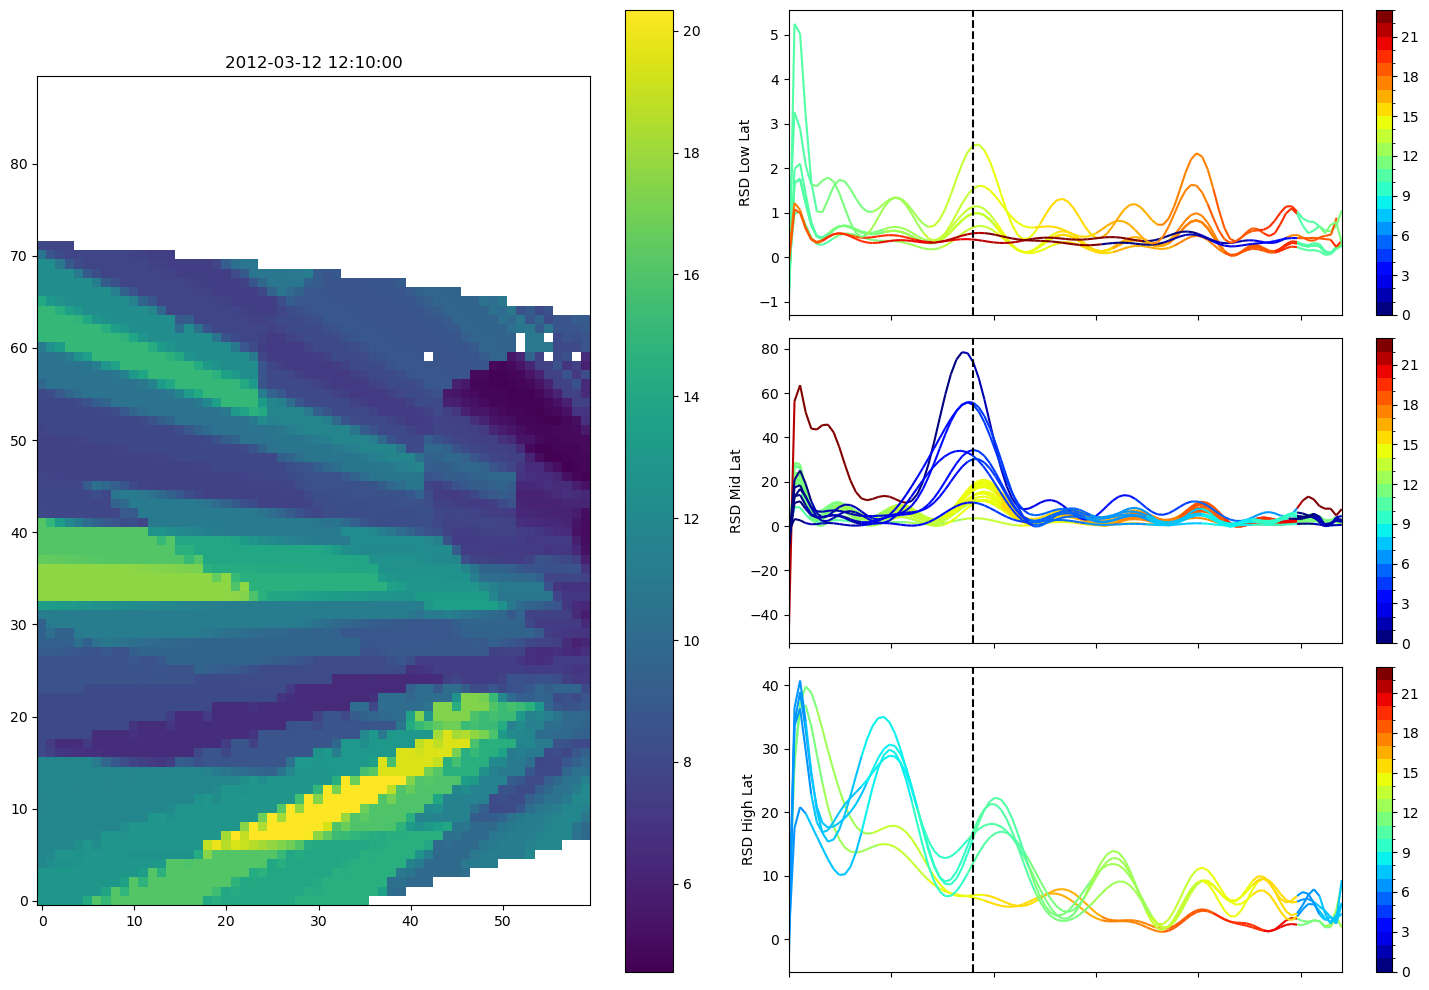

In [152]:
fig = plt.figure(figsize=(15,10))
ax1 = plt.subplot(121)
plt.imshow(maps_array[i], origin='lower')
plt.title(dates[i])
plt.colorbar()

colormap = plt.get_cmap('jet')
norm = BoundaryNorm([j for j in range(0,24)], colormap.N)

ax2 = plt.subplot(322)
for region in dataframes.keys():

	if dataframes[region]['mlat'] > 50:
		continue

	df = dataframes[region]['df']

	temp = df['rsd'][plot_start:plot_end].dropna(inplace=False)
	if len(temp) == 0:
		continue
	polyx = [n for n in range(len(temp))]

	polyy = temp.values

	try:
		coeff = np.polyfit(polyx, polyy, rsd_degree)
	except np.linalg.LinAlgError:
		coeff = np.polyfit(polyx, polyy, int(rsd_degree/2))


	poly = np.poly1d(coeff)

	x_fit = np.linspace(min(polyx), max(polyx), 100)
	y_fit = poly(x_fit)

	inxval = mdates.date2num(df['rsd'][plot_start:plot_end].index)
	# points = np.array([inxval, df['rsd'][plot_start:plot_end].values]).T.reshape(-1,1,2)
	points = np.array([x_fit, y_fit]).T.reshape(-1,1,2)
	segments = np.concatenate([points[:-1], points[1:]], axis=1)

	lc = LineCollection(segments, cmap=colormap, norm=norm)
	mlt_coloring_array = [df['MLT'][plot_start:plot_end][m] for m in range(0,len(temp), math.ceil(len(temp)/100))]
	lc.set_array(mlt_coloring_array)
	ax2.add_collection(lc)

# x_ticks = [k for k in range(0, len(time_period), int((len(time_period)/len(ax4.get_xticklabels())))-1)]
ax2.set_xticklabels([])
ax2.set_ylabel('RSD Low Lat')
ax2.autoscale_view()
plt.colorbar(lc)
plt.axvline(int((hours_before/(hours_before+hours_after))*len(time_period)), linestyle='--', color='black')
plt.margins(x=0)


ax3 = plt.subplot(324)
for region in dataframes.keys():

	if (dataframes[region]['mlat'] <= 50) or ((dataframes[region]['mlat'] > 70)):
		continue
	
	df = dataframes[region]['df']

	temp = df['rsd'][plot_start:plot_end].dropna(inplace=False)
	if len(temp) == 0:
		continue
	polyx = [n for n in range(len(temp))]

	polyy = temp.values

	try:
		coeff = np.polyfit(polyx, polyy, rsd_degree)
	except np.linalg.LinAlgError:
		coeff = np.polyfit(polyx, polyy, int(rsd_degree/2))


	poly = np.poly1d(coeff)

	x_fit = np.linspace(min(polyx), max(polyx), 100)
	y_fit = poly(x_fit)

	inxval = mdates.date2num(df['rsd'][plot_start:plot_end].index)
	# points = np.array([inxval, df['rsd'][plot_start:plot_end].values]).T.reshape(-1,1,2)
	points = np.array([x_fit, y_fit]).T.reshape(-1,1,2)
	segments = np.concatenate([points[:-1], points[1:]], axis=1)

	lc = LineCollection(segments, cmap=colormap, norm=norm)
	mlt_coloring_array = [df['MLT'][plot_start:plot_end][m] for m in range(0,len(temp), math.ceil(len(temp)/100))]
	lc.set_array(mlt_coloring_array)
	ax3.add_collection(lc)

# x_ticks = [k for k in range(0, len(time_period), int((len(time_period)/len(ax4.get_xticklabels())))-1)]
ax3.set_xticklabels([])
ax3.set_ylabel('RSD Mid Lat')
ax3.autoscale_view()
plt.colorbar(lc)
plt.axvline(int((hours_before/(hours_before+hours_after))*len(time_period)), linestyle='--', color='black')
plt.margins(x=0)


ax4 = plt.subplot(326)
for region in dataframes.keys():

	if dataframes[region]['mlat'] <= 70:
		continue
	
	df = dataframes[region]['df']

	temp = df['rsd'][plot_start:plot_end].dropna(inplace=False)
	if len(temp) == 0:
		continue
	polyx = [n for n in range(len(temp))]

	polyy = temp.values

	try:
		coeff = np.polyfit(polyx, polyy, rsd_degree)
	except np.linalg.LinAlgError:
		coeff = np.polyfit(polyx, polyy, int(rsd_degree/2))


	poly = np.poly1d(coeff)

	x_fit = np.linspace(min(polyx), max(polyx), 100)
	y_fit = poly(x_fit)

	inxval = mdates.date2num(df['rsd'][plot_start:plot_end].index)
	# points = np.array([inxval, df['rsd'][plot_start:plot_end].values]).T.reshape(-1,1,2)
	points = np.array([x_fit, y_fit]).T.reshape(-1,1,2)
	segments = np.concatenate([points[:-1], points[1:]], axis=1)

	lc = LineCollection(segments, cmap=colormap, norm=norm)
	mlt_coloring_array = [df['MLT'][plot_start:plot_end][m] for m in range(0,len(temp), math.ceil(len(temp)/100))]
	lc.set_array(mlt_coloring_array)
	ax4.add_collection(lc)
# x_ticks = [k for k in range(0, len(time_period)+1, int((len(time_period)/len(ax4.get_xticklabels()))))]
# ax4.set_xticklabels(time_period[x_ticks], rotation=45, ha='right')
ax4.set_xticklabels([])
ax4.set_ylabel('RSD High Lat')
ax4.autoscale_view()
plt.colorbar(lc)
plt.axvline(int((hours_before/(hours_before+hours_after))*len(time_period)), linestyle='--', color='black')
plt.margins(x=0)

plt.tight_layout()
plt.show()